In [1]:
import pandas as pd
nifty_1day = pd.read_csv('../../nifty_daily_continous.csv')
nifty_1day['datetime'] =  pd.to_datetime(nifty_1day['datetime'], infer_datetime_format=True)
nifty_1day = nifty_1day.set_index("datetime")
nifty_1day = nifty_1day[nifty_1day.index >= '2011-01-03']
nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['abs_returns'].cumsum()
nifty_1day["cumulative_returns"] = ((1 + nifty_1day["pct_returns"]).cumprod() - 1)+1
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100

2011-02-22, Close, 5469.20
2011-02-22, BUY CREATE, 5469.20
2011-02-23, BUY EXECUTED, Price: 5452.45, Cost: 5452.45, Comm 0.00
2011-02-23, Close, 5437.35
2011-02-24, Close, 5262.70
2011-02-24, SELL CREATE, 5262.70
2011-02-25, SELL EXECUTED, Price: 5321.05, Cost: 5452.45, Comm 0.00
2011-02-25, OPERATION PROFIT, GROSS -131.40, NET -131.40
2011-02-25, Close, 5303.55
2011-02-28, Close, 5333.25
2011-03-01, Close, 5522.30
2011-03-01, BUY CREATE, 5522.30
2011-03-03, BUY EXECUTED, Price: 5478.45, Cost: 5478.45, Comm 0.00
2011-03-03, Close, 5536.20
2011-03-04, Close, 5538.75
2011-03-07, Close, 5463.15
2011-03-08, Close, 5520.80
2011-03-09, Close, 5531.00
2011-03-10, Close, 5494.40
2011-03-11, Close, 5445.45
2011-03-11, SELL CREATE, 5445.45
2011-03-14, SELL EXECUTED, Price: 5436.50, Cost: 5478.45, Comm 0.00
2011-03-14, OPERATION PROFIT, GROSS -41.95, NET -41.95
2011-03-14, Close, 5531.50
2011-03-14, BUY CREATE, 5531.50
2011-03-15, BUY EXECUTED, Price: 5420.00, Cost: 5420.00, Comm 0.00
2011-03-15,

'figure = cerebro.plot()[0][0]\n\n# show the plot in Streamlit\nst.pyplot(figure)'

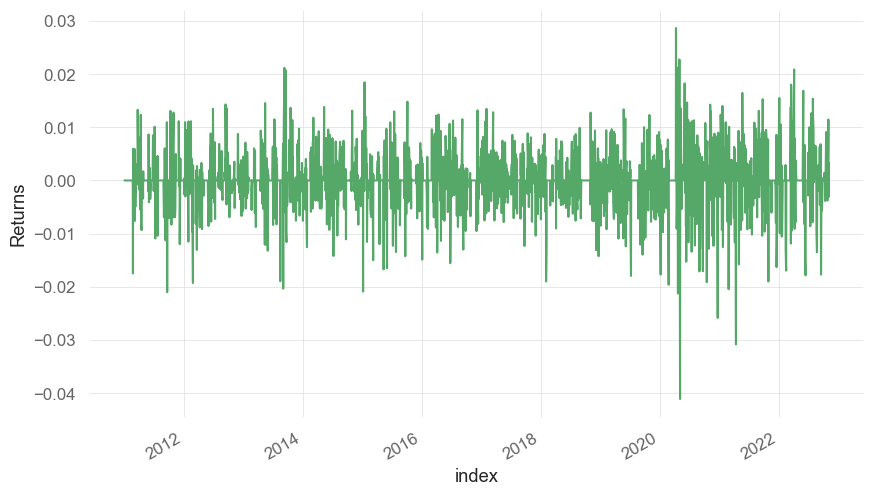

In [111]:
import pandas as pd
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st
import seaborn as sns

class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order is not None:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')

data = bt.feeds.YahooFinanceCSVData(
        dataname='../../nifty_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)
cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
results = cerebro.run()
strat = results[0]


portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Nifty Sentiment')

# Plot the cumulative sum using Pyfolio
pf.plotting.plot_returns(returns)
'''plt.plot(nifty_1day['cumulative_returns'], label='actual')
plt.legend()
plt.savefig("data.png")'''

'''figure = cerebro.plot()[0][0]

# show the plot in Streamlit
st.pyplot(figure)'''

In [124]:
import pandas as pd
import datetime
import backtrader as bt
import matplotlib.pyplot as plt
import quantstats as qs
import pyfolio as pf
import streamlit as st
import numpy as np

class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order is not None:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')

data = bt.feeds.YahooFinanceCSVData(
        dataname='../../nifty_daily_continous.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2022, 11, 7),
        # Do not pass values after this date
        reverse=False)
cerebro.adddata(data)

cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

results = cerebro.run()
strat = results[0]

portfolio_stats = strat.analyzers.getbyname('PyFolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

cum_rets = qs.stats.compsum(returns)
drawdown_df = qs.stats.to_drawdown_series(returns)
distribution_stats = pf.timeseries.calc_distribution_stats(returns)

2011-02-22, Close, 5469.20
2011-02-22, BUY CREATE, 5469.20
2011-02-23, BUY EXECUTED, Price: 5452.45, Cost: 5452.45, Comm 0.00
2011-02-23, Close, 5437.35
2011-02-24, Close, 5262.70
2011-02-24, SELL CREATE, 5262.70
2011-02-25, SELL EXECUTED, Price: 5321.05, Cost: 5452.45, Comm 0.00
2011-02-25, OPERATION PROFIT, GROSS -131.40, NET -131.40
2011-02-25, Close, 5303.55
2011-02-28, Close, 5333.25
2011-03-01, Close, 5522.30
2011-03-01, BUY CREATE, 5522.30
2011-03-03, BUY EXECUTED, Price: 5478.45, Cost: 5478.45, Comm 0.00
2011-03-03, Close, 5536.20
2011-03-04, Close, 5538.75
2011-03-07, Close, 5463.15
2011-03-08, Close, 5520.80
2011-03-09, Close, 5531.00
2011-03-10, Close, 5494.40
2011-03-11, Close, 5445.45
2011-03-11, SELL CREATE, 5445.45
2011-03-14, SELL EXECUTED, Price: 5436.50, Cost: 5478.45, Comm 0.00
2011-03-14, OPERATION PROFIT, GROSS -41.95, NET -41.95
2011-03-14, Close, 5531.50
2011-03-14, BUY CREATE, 5531.50
2011-03-15, BUY EXECUTED, Price: 5420.00, Cost: 5420.00, Comm 0.00
2011-03-15,

In [166]:
nifty_1day = pd.read_csv("../../nifty_daily_continous.csv")
nifty_1day['datetime'] =  pd.to_datetime(nifty_1day['datetime'], format='%Y-%m-%d %H:%M:%S')
nifty_1day = nifty_1day[nifty_1day.datetime >= '2011-01-03']
nifty_1day = nifty_1day[nifty_1day.datetime < '2022-11-7']
nifty_1day['datetime'] = nifty_1day['datetime'].dt.date

#cum_rets = pd.DataFrame({'DATE':cum_rets.index, 'cum_rets':cum_rets.values})
nifty_1day["cumulative_returns"] = cum_rets.values

#drawdown_df = pd.DataFrame({'DATE':drawdown_df.index, 'DRAWDOWN':drawdown_df.values})
nifty_1day["drawdown"] = drawdown_df.values

nifty_1day["pct_returns"] = nifty_1day["close"].pct_change()
nifty_1day["abs_returns"] = nifty_1day["close"].diff()
nifty_1day['cumsum'] = nifty_1day['cumulative_returns'].apply(lambda x: x*4007.399718318368)
nifty_1day["pct_returns"] = nifty_1day["pct_returns"] * 100

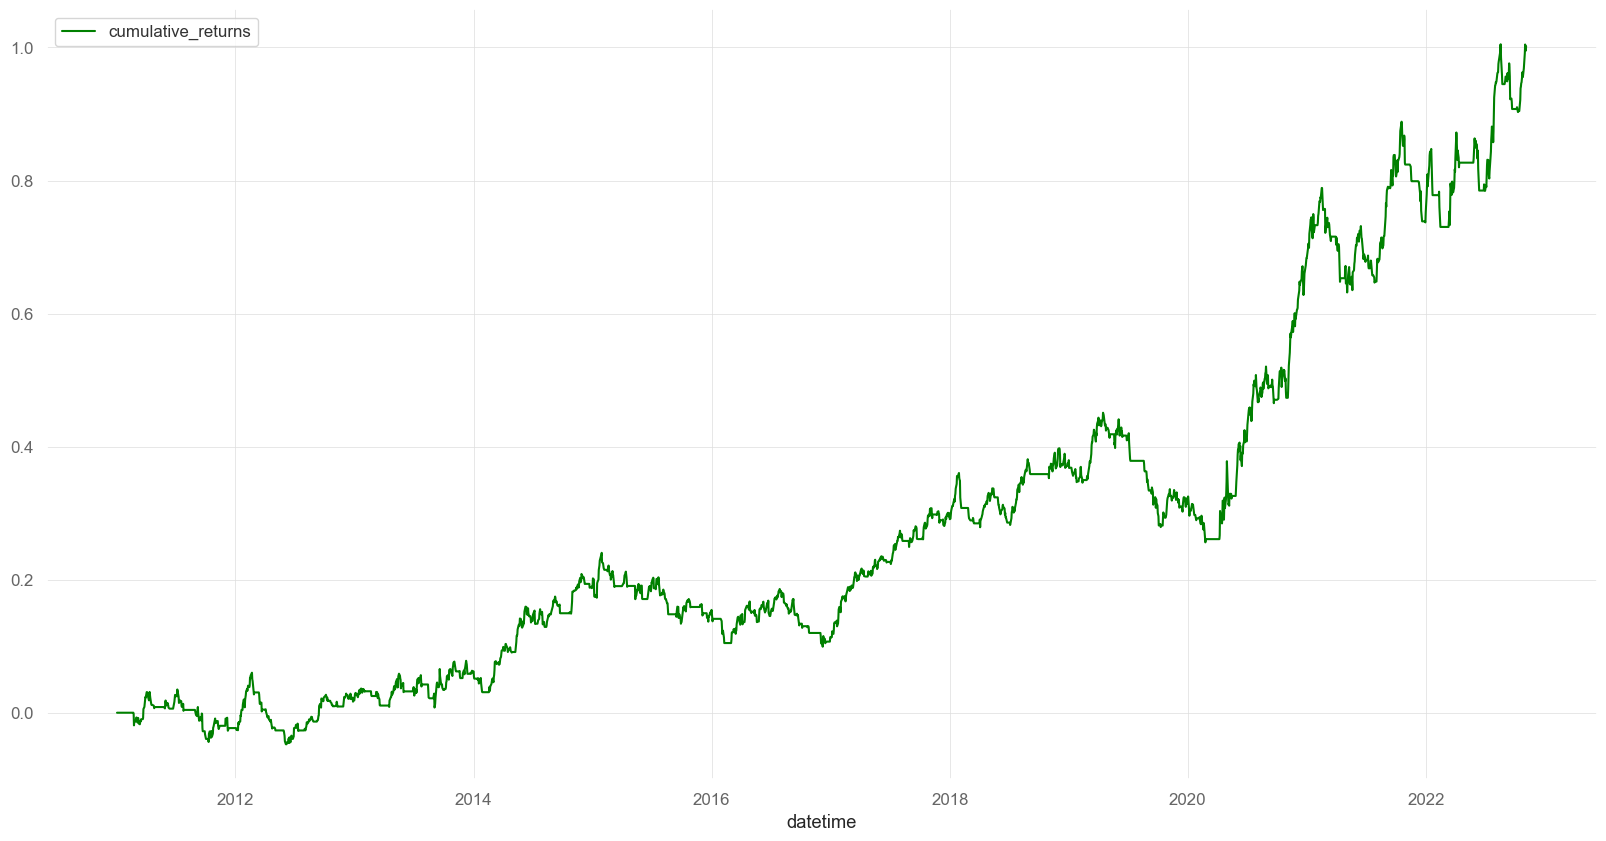

In [131]:
## cumulative returns in percentage 
nifty_1day.plot(x = 'datetime', y = ['cumulative_returns'], figsize=(20,10), color = "green")

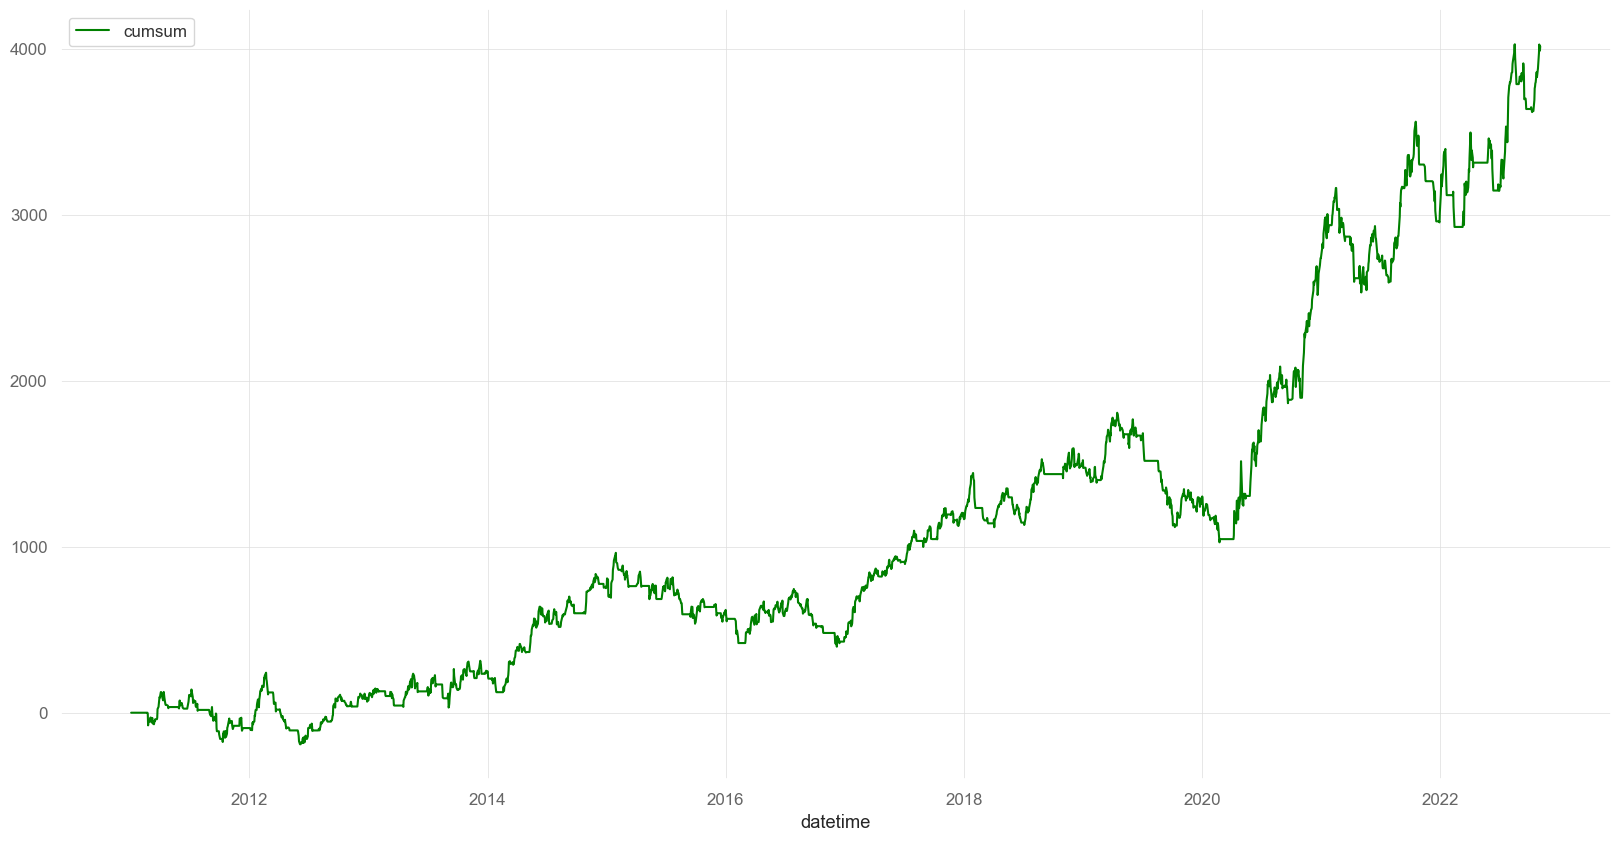

In [132]:
## cummulative returns in rupees / absolute returns
nifty_1day.plot(x = 'datetime', y = ['cumsum'], figsize=(20,10), color = "green")

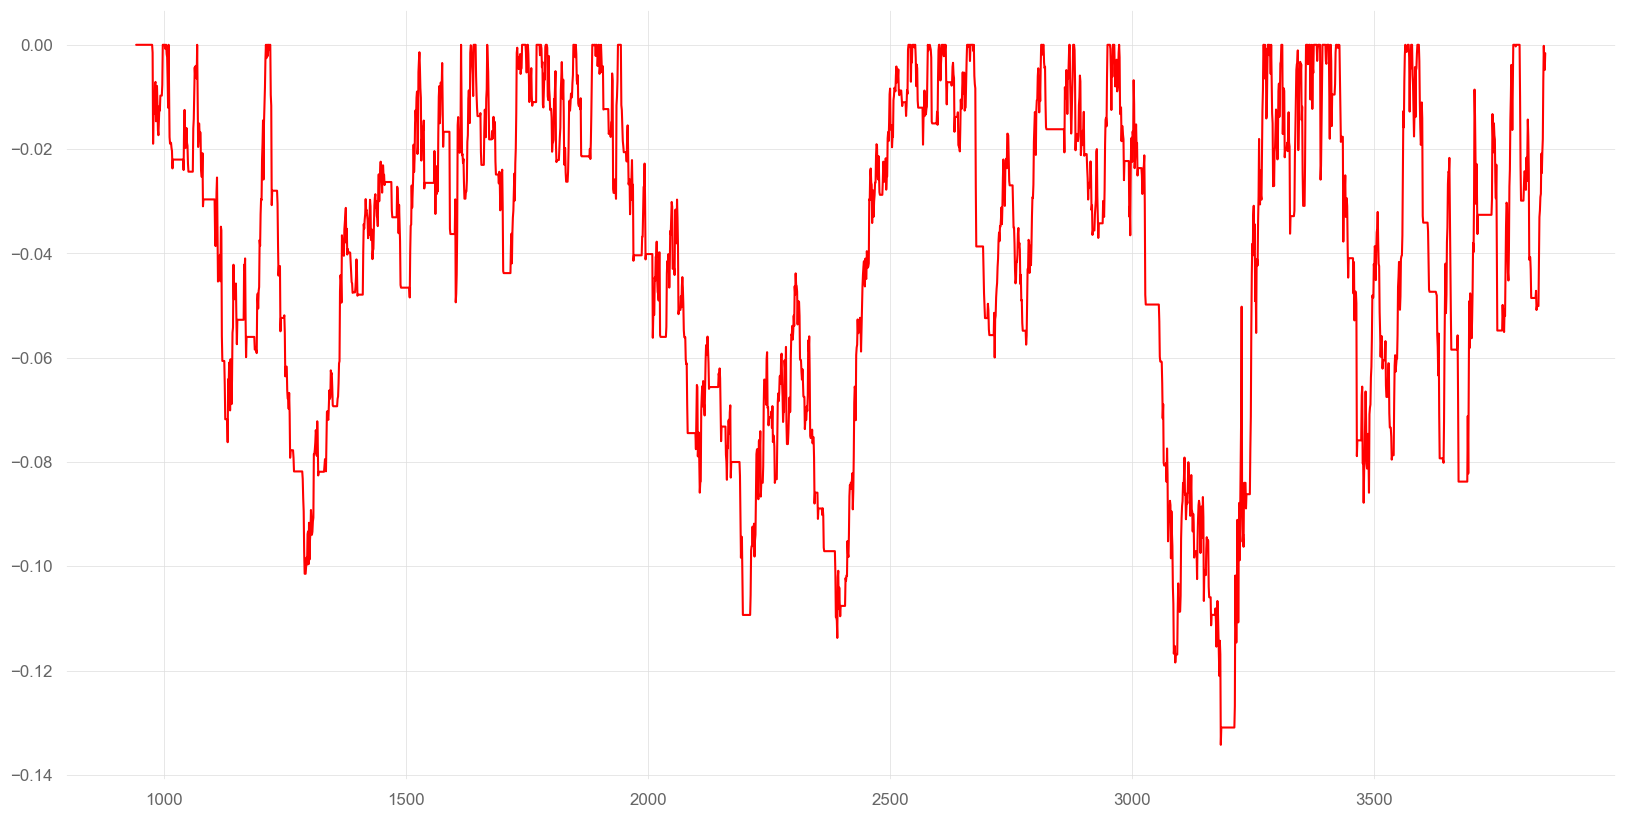

In [133]:
nifty_1day["drawdown"].plot(figsize=(20,10),color = 'red')

In [11]:
max_drawdown = qs.stats.max_drawdown(returns)
max_drawdown

-0.1342442621820933

In [12]:
# Calculate the percentage of time the strategy is in drawdown
drawdown_periods = nifty_1day[nifty_1day["drawdown"] < 0]['drawdown'].count()
total_periods = nifty_1day["cumulative_returns"].count()
percent_in_drawdown = drawdown_periods / total_periods * 100
print("Percentage of time in drawdown: {:.2f}%".format(percent_in_drawdown))

Percentage of time in drawdown: 92.37%


In [13]:
nifty_1day[nifty_1day['drawdown']==0].reset_index()

,index,datetime,open,high,low,close,adj close,volume,cumulative_returns,drawdown,pct_returns,abs_returns,cumsum
0,943,2011-01-03,6177.45,6178.55,6147.20,6157.60,6157.60,615343104,0.000000,0.0,NaN,NaN,NaN
1,944,2011-01-04,6172.75,6181.05,6124.40,6146.35,6146.35,732465778,0.000000,0.0,-0.182701,-11.25,-11.25
2,945,2011-01-05,6141.35,6141.35,6062.35,6079.80,6079.80,621724540,0.000000,0.0,-1.082756,-66.55,-77.80
3,946,2011-01-06,6107.00,6116.15,6022.30,6048.25,6048.25,623468238,0.000000,0.0,-0.518932,-31.55,-109.35
4,947,2011-01-07,6030.90,6051.20,5883.60,5904.60,5904.60,672038638,0.000000,0.0,-2.375067,-143.65,-253.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,3796,2022-08-11,17711.65,17719.30,17631.95,17659.00,17659.00,220141683,0.975070,0.0,0.708593,124.25,11501.40
218,3797,2022-08-12,17659.65,17724.65,17597.85,17698.15,17698.15,242553351,0.978985,0.0,0.221700,39.15,11540.55
219,3798,2022-08-16,17797.20,17839.10,17764.05,17825.25,17825.25,251074992,0.991695,0.0,0.718154,127.10,11667.65
220,3799,2022-08-17,17868.15,17965.95,17833.35,17944.25,17944.25,266886072,1.003595,0.0,0.667592,119.00,11786.65


## Monte carlo simulation for above strategy

In [14]:
import seaborn as sns

In [167]:
df_ret = nifty_1day[['datetime','pct_returns']].copy()
df_ret.rename(columns = {'datetime':'date','pct_returns':'ret'},inplace=True)

In [168]:
df_ret.reset_index(inplace = True, drop = True)

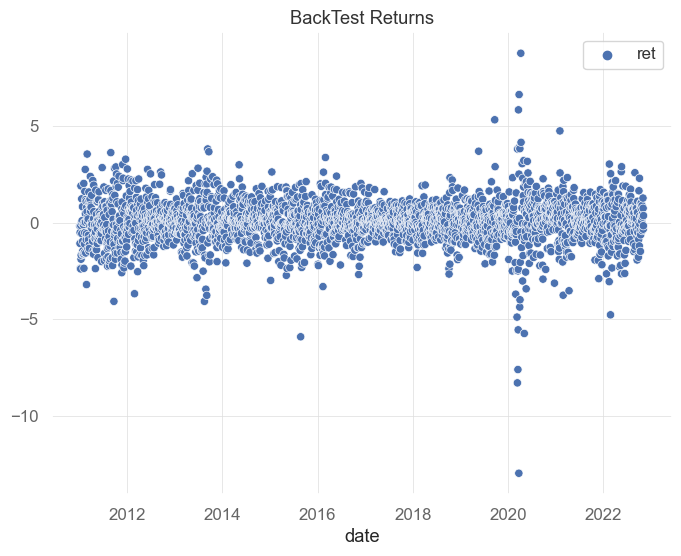

In [169]:
## Plot a Scatter Plot daily returns of the strategy to get an idea of distribution of returns. 
fig,ax=plt.subplots(1,1,figsize=(8,6),sharey=True)
sns.scatterplot(ax=ax,data=df_ret.set_index('date'))
ax.set_title('BackTest Returns')
ax.grid(True,axis='both')

In [163]:
# Create a Function to Calculate Maximum Drawdown for a given data series
def calc_max_dd(data_series):
    '''
    Inputs:
    data_series (pd.Series): A series of percentage returns of the strategy
    Returns:
    Maximum Drawdown (float)
    '''
    cumm_ret=data_series.cumsum()
    
    hwm=cumm_ret.cummax()
    dd=cumm_ret-hwm
    return round(dd.min(),2)

In [164]:
## Calculate Maximum Drawdown of Strategy in the Backtest
max_dd = calc_max_dd(df_ret['ret'])
print(f'The Maximum Drawdown of this Strategy Backtest is: {max_dd} and Total No. of Trades are: {len(df_ret)}')

The Maximum Drawdown of this Strategy Backtest is: nan and Total No. of Trades are: 2911


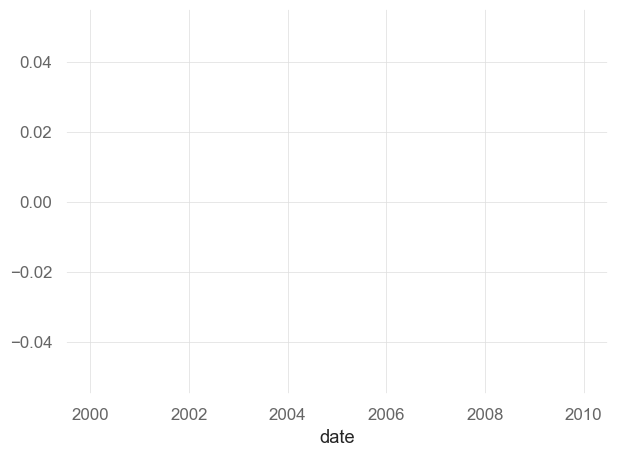

In [165]:
# Visualize the Equity Curve of Our Backtest
df_ret.set_index(df_ret['date'])['ret'].cumsum().plot(figsize=(7,5))

In [106]:
## Define a function to conduct Monte Carlo Simulations
def monte_carlo(simulations,df):
  '''
  Args
  simulations(int) : No. of Simulations to Run for Monte Carlo
  df (DataFrame): DataFrame of Returns with 'ret' as column name for returns
  '''
  mdd_list=[]
  for s in range(simulations):
    mdd=0
    reshuffle=df['ret'].sample(frac=0).reset_index(drop=True)
    plt.plot(reshuffle.cumsum())
    mdd=calc_max_dd(reshuffle)
    mdd_list.append(mdd)
  plt.plot(df['ret'],linewidth=3,color='black')
  plt.xlabel('Trade No.')
  plt.ylabel('Cummulative Returns')
  plt.title('Monte Carlo Simulation for {} Simulations'.format(simulations))
  plt.show()
  return mdd_list

In [108]:
def monte_carlo_simulation(num_simulations, cumulative_returns):
    """
    Perform Monte Carlo simulation using cumulative returns and plot the results.

    Parameters:
    - num_simulations (int): Number of simulations to run
    - cumulative_returns (pandas dataframe): Dataframe of cumulative returns

    Returns:
    - results (pandas dataframe): Dataframe of simulation results
    """
    results = pd.DataFrame()
    
    for i in range(num_simulations):
        simulated_returns = np.random.normal(cumulative_returns.mean(), cumulative_returns.std(), cumulative_returns.shape[0])
        simulated_returns = np.cumprod(simulated_returns + 1) - 1
        results[i] = simulated_returns
    
    plt.figure(figsize=(12,8))
    results.plot(legend=False)
    plt.xlabel("Time")
    plt.ylabel("Cumulative Returns")
    plt.title("Monte Carlo Simulation Results")
    plt.show()
    
    return results

<Figure size 800x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

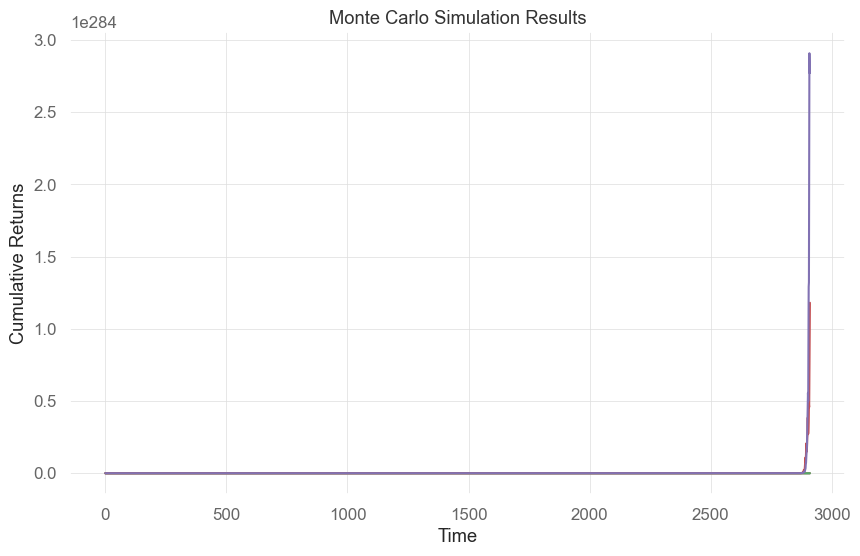

In [109]:
simulations=5
plt.figure(figsize=(8,6))
mdd_list=monte_carlo_simulation(simulations,df_ret)

In [79]:
mdd_list

[-46.35, -38.95, -60.09, -36.82, -43.82]

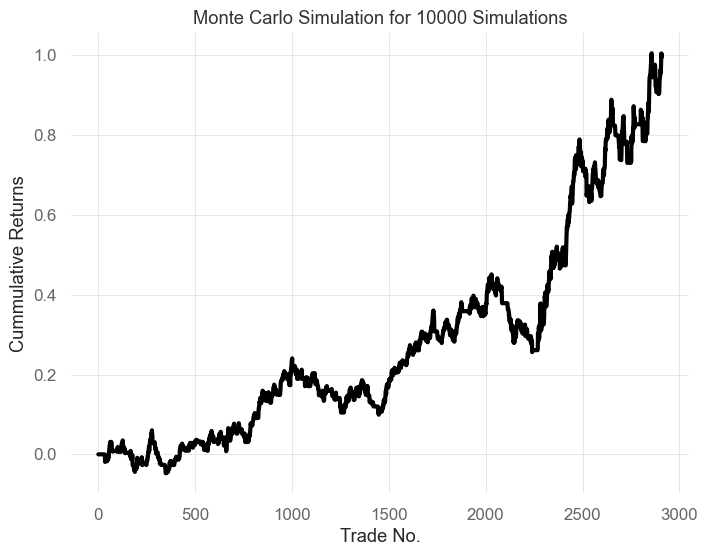

In [105]:
simulations=10000
plt.figure(figsize=(8,6))
mdd_list=monte_carlo(simulations,df_ret)